# Машинное обучение

## Факультет математики НИУ ВШЭ

### 2018-2019 учебный год

Лектор: Илья Щуров

Семинаристы: Соня Дымченко, Руслан Хайдуров

Ассистенты: Александр Каган, Павел Балтабаев

# Семинар 9

Сегодня мы:

- познакомимся с новым алгоритмом машинного обучения - решающим деревом

- напишем код для разбиения вершины

- <s>посадим дерево, вырастим сына, построим дом </s>

### Решающие деревья

<img src='tree_example.png'>

Сами по себе решающие деревья используются в машинном обучении относительно редко, однако очень распространены методы, основанные на их композиции - ансамблях (Random Forest, XGBoost, LightGBM).

##### Плюсы:

- интерпретируемость
- способность выделить самые важные признаки
- отсутствие потребности в серьезной предобработке данных

##### Минусы:

- склонность к переобучению
- неустойчивость - небольшие изменения в данных могут привести к сильному изменению в структуре дерева
- эвристичность обучения - как оптимизировать?

#####  Линейная модель vs "деревянная" модель (основанная на решающих деревьях):

- когда данные хорошо линейно разделимы, линейная модель лучше

- когда данные плохо линейно разделимы (много сложных нелинейных зависимостей в данных), "деревянная" модель лучше

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (15, 6)

### Переобучение

In [3]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

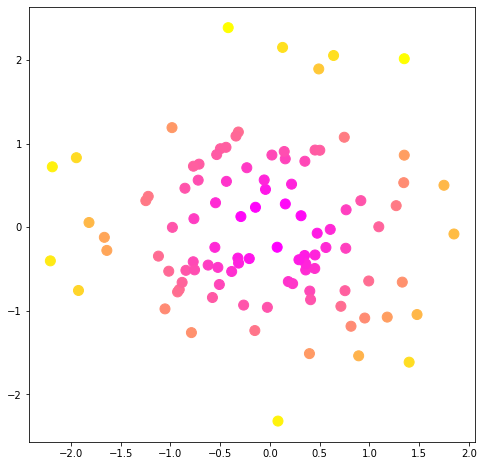

In [4]:
np.random.seed(13)
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5 # 
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

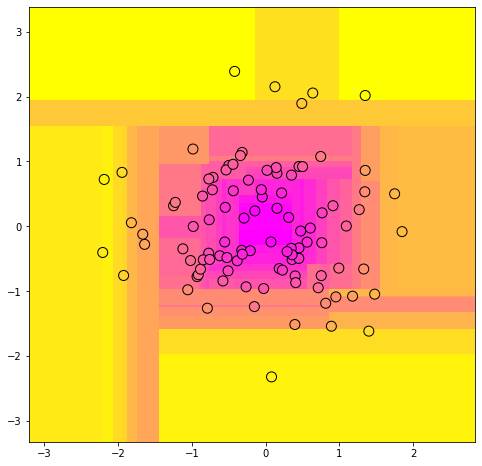

In [5]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(random_state=13)
clf.fit(data_x, data_y)

xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')
plt.show()

Посмотрим, как будет выглядеть разделение плоскости в зависимости от максимальной глубины дерева и минимального числа объектов в листе.

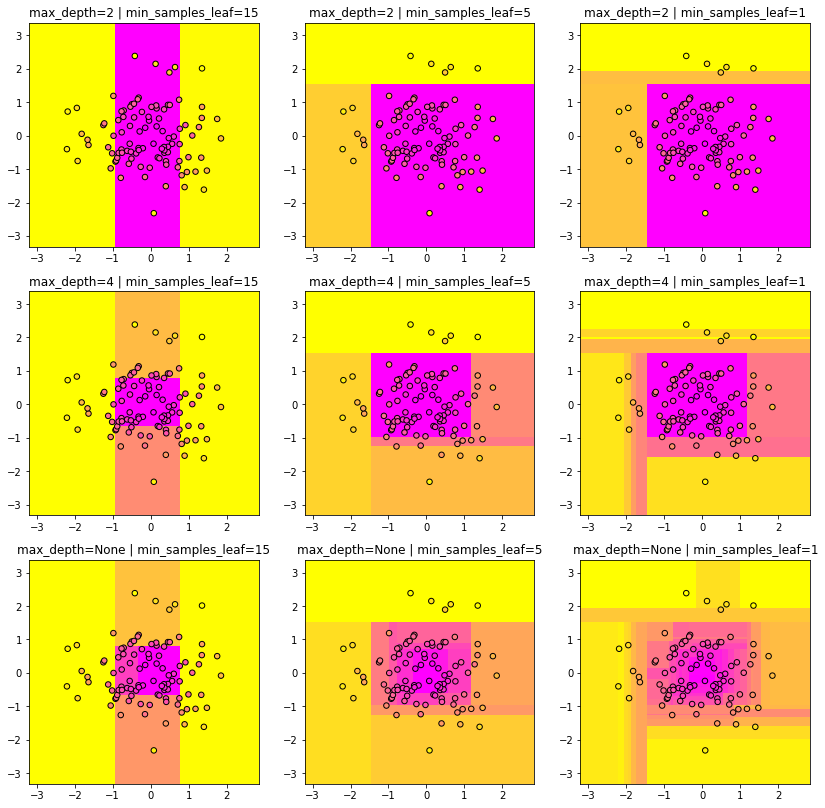

In [6]:
plt.figure(figsize=(14, 14))
for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=13)
        clf.fit(data_x, data_y)
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ' | min_samples_leaf=' + str(min_samples_leaf))

### Неустойчивость

Посмотрим, как будет меняться структура дерева, если брать для обучения разные 90%-ые подвыборки исходной выборки.

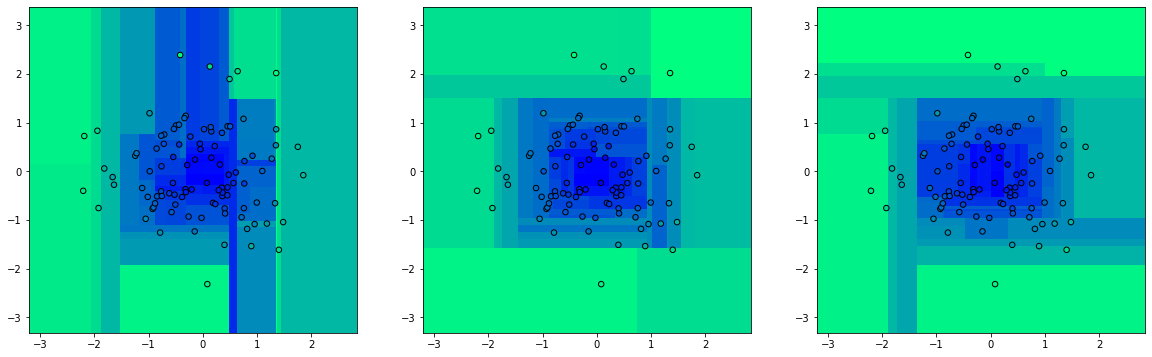

In [7]:
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=13)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

### Практика

In [8]:
boston = load_boston()

In [9]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [10]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [11]:
boston['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [12]:
boston['data'].shape

(506, 13)

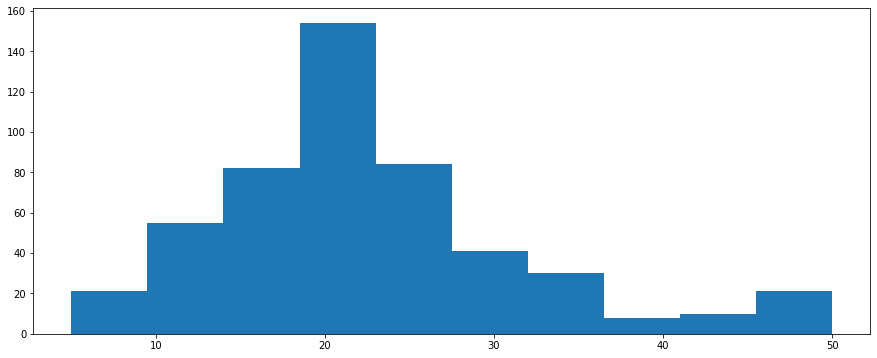

In [13]:
plt.hist(boston['target'])
plt.show()

In [14]:
data_train, data_test, y_train, y_test = train_test_split(boston['data'], boston['target'], random_state=13)

In [15]:
X_train = pd.DataFrame(data_train, columns=boston['feature_names'])
X_test = pd.DataFrame(data_test, columns=boston['feature_names'])
X_train['target'] = y_train

In [16]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.17171,25.0,5.13,0.0,0.453,5.966,93.4,6.8185,8.0,284.0,19.7,378.08,14.44,16.0
1,0.12083,0.0,2.89,0.0,0.445,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
2,0.62976,0.0,8.14,0.0,0.538,5.949,61.8,4.7075,4.0,307.0,21.0,396.90,8.26,20.4
3,0.25199,0.0,10.59,0.0,0.489,5.783,72.7,4.3549,4.0,277.0,18.6,389.43,18.06,22.5
4,0.10793,0.0,8.56,0.0,0.520,6.195,54.4,2.7778,5.0,384.0,20.9,393.49,13.00,21.7


In [17]:
X_train.shape, X_test.shape

((379, 14), (127, 13))

### Построение разбиения своими руками
При построении дерева необходимо задать функционал качества, на основе которого осуществляется разбиение выборки на каждом шаге. 

Пусть $R_m$ - множество объектов в разбиваемой вершине, $R_\ell$ и $R_r$ - множества объектов в левом и право поддереве при заданном предикате. 
Тогда функционал качества:

$$
Q(R_m, i, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$
где $i$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения.

$H(R)$ - критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

_Вопрос. Что мы хотим сделать с $H(R)$ - минимизировать или максимизировать? А $Q(R_m, i, t)$?_

_Вопрос. Что можно использовать в качестве критерия информативности для регрессии? *А для классификации?_

_Реализуйте подсчет качества разбиения._

In [ ]:
def H(R):
    # your code here
    return


def split_node(R_m, feature, t):
    # your code here
    return R_l, R_r


def quality(R_m, feature, t):
    # your code here
    return Q

_Переберите все возможные разбиения выборки по одному из признаков и постройте график качества разбиения в зависимости от значения порога._

In [ ]:
# your code here

_Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку._

In [ ]:
def get_optimal_split(R_m, feature):
    # your code here
    return t, Q_arr

_Постройте график качества разбиения (в зависимости от количества объектов в левом поддереве) для каждого из признаков. Найдите признак, показывающий наилучшее качество. Какой это признак? Каков порог разбиения и значение качества? Постройте график качества разбиения для данного признака в зависимости от значения порога._

In [ ]:
# your code here

_Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния (plt.scatter) целевой переменной в зависимости от значения найденного признака. Далее изобразите вертикальную линию, соответствующую разбиению (plt.vlines). Почему это разбиение лучшее? Как вы можете проинтерпретировать результат?_

In [ ]:
# your code here